<a href="https://colab.research.google.com/github/SergChupin/PyTorch/blob/main/HW_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
import os
import numpy as np
import pandas as pd
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
def func(x):
    y = (np.sin(x) / x) - (x / 10)
    return y

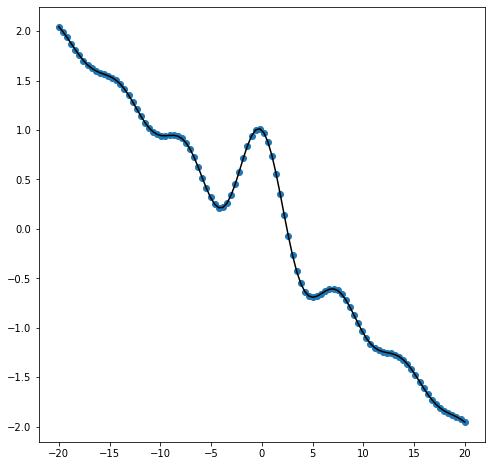

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
x = np.linspace(-20, 20, 100)
ax.scatter(x, y = func(x))
plt.plot(x, func(x), color='black')
plt.show()

In [4]:
def points_generator(ax, n):
    points = pd.DataFrame([(x, func(x)) for x in np.random.uniform(-ax, ax, size=(1, n))[0]], columns=['x', 'y'])
    return points

In [5]:
df_train = points_generator(10, 500000)
df_train

,x,y
0,-0.134664,1.010447
1,4.173218,-0.622951
2,-4.960803,0.300688
3,-1.918707,0.681829
4,9.895222,-1.035330
...,...,...
499995,-7.168073,0.824764
499996,6.685804,-0.609974
499997,-9.632654,0.941840
499998,7.933691,-0.667725


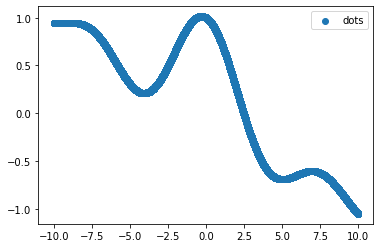

In [6]:
x, y = df_train.values.T
plt.scatter(x, y, label='dots')
plt.legend()
plt.show()

In [7]:
scaler = MinMaxScaler()

data_train = scaler.fit_transform(df_train)  
data_train = torch.FloatTensor(data_train).float()
data_train

tensor([[0.4933, 0.9978],
        [0.7087, 0.2085],
        [0.2520, 0.6548],
        ...,
        [0.0184, 0.9646],
        [0.8967, 0.1868],
        [0.0779, 0.9651]])

In [8]:
class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        dot = self._data[idx] 
       
        return dot

In [9]:
train_dataset = MyOwnClass(data_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [10]:
for idx, batch in enumerate(train_loader):
    print(batch.shape) 
    break

torch.Size([128, 2])


In [11]:
def plot_dots(generated_dots, real_dots):
    fig, ax = plt.subplots(figsize=(8, 8))

    a ,b = (real_dots.detach()).T
    plt.scatter(a, b, color='red',label='Real dots') 
    
    x, y = (gen_dots.detach()).T
    plt.scatter(x, y, color='black', label='Generated dots') 

    plt.legend()
    plt.show()

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, z):
        dots = self.model(z)
        dots = dots.reshape(-1, 2)
        return dots

In [13]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

In [14]:
layer = CustomLinearLayer(1, 2)
layer.weights, layer.bias

(Parameter containing:
 tensor([[ 0.0009],
         [-0.0011]], requires_grad=True), Parameter containing:
 tensor([ 0.0001, -0.0040], requires_grad=True))

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.reshape(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [16]:
n_epochs = 20  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 500  # количество итераций для отображения процесса обучения

In [17]:
generator = Generator()
discriminator = Discriminator()

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [18]:
d_loss_history = []
g_loss_history = []

In [19]:
batch_size = 128

<Figure size 432x288 with 0 Axes>

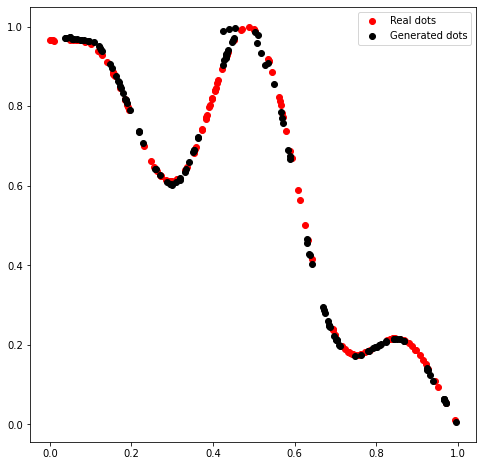

[Epoch 19/20] [Batch 3786/3906]|[D loss: 0.6884332299232483] [G loss: 0.7218692898750305]


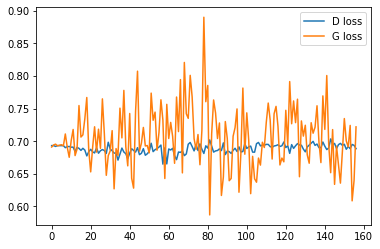

In [20]:
for epoch in range(n_epochs):
    for i, dots in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0)

        real_dots = dots.type(torch.FloatTensor)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))

        # Генерируем данные Генератором на основе шума
        gen_dots = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_dots)
                
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_dots)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        
        # Генерируем данные Генератором на основе шума
        gen_dots = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_dots)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                plot_dots(gen_dots, real_dots)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()